In [63]:
#importing libraries
import pandas as pd
from pandas import Grouper
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import calendar

# Geovisualization library
import folium
from folium.plugins import CirclePattern, HeatMap, HeatMapWithTime

In [64]:
data = pd.read_csv('citibike.csv', header='infer')

In [11]:
data.shape

(50000, 18)

In [13]:
#checking for null/missing values
data.isna().sum()

trip_id                       0
bike_id                       0
weekday                       0
start_hour                    0
start_time                    0
start_station_id              0
start_station_name            0
start_station_latitude        0
start_station_longitude       0
end_time                      0
end_station_id                0
end_station_name              0
end_station_latitude          0
end_station_longitude         0
trip_duration                 0
subscriber                    0
birth_year                 6979
gender                        0
dtype: int64

In [72]:
#dropping index with null values
data = data.dropna()

In [73]:
#converting Birth Year from Float to Int
data['birth_year'] = data['birth_year'].apply(np.int64)

In [74]:
data.head()

,trip_id,bike_id,weekday,start_hour,start_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_time,end_station_id,end_station_name,end_station_latitude,end_station_longitude,trip_duration,subscriber,birth_year,gender
0,LnQzQk,16013,Mon,18,2013-09-09 18:18:55,523,W 38 St & 8 Ave,40.754666,-73.991382,2013-09-09 18:35:28,334,W 20 St & 7 Ave,40.742388,-73.997262,993,Subscriber,1968,2
1,IL9boN,15230,Thu,18,2013-09-12 18:38:53,257,Lispenard St & Broadway,40.719392,-74.002472,2013-09-12 18:48:34,236,St Marks Pl & 2 Ave,40.728419,-73.987140,581,Subscriber,1983,1
2,46clGB,17942,Wed,19,2013-09-18 19:44:04,479,9 Ave & W 45 St,40.760193,-73.991255,2013-09-18 19:50:05,513,W 56 St & 10 Ave,40.768254,-73.988639,361,Subscriber,1989,1
3,v7vdFt,19683,Sat,11,2013-09-28 11:54:37,527,E 33 St & 1 Ave,40.743156,-73.974347,2013-09-28 12:03:58,441,E 52 St & 2 Ave,40.756014,-73.967416,561,Subscriber,1988,2
5,HbKJBz,14581,Fri,22,2013-09-27 22:01:01,293,Lafayette St & E 8 St,40.730287,-73.990765,2013-09-27 22:08:08,432,E 7 St & Avenue A,40.726218,-73.983799,427,Subscriber,1986,2


In [75]:
#dropping the index with gender code  = 0
data = data.drop(data[data.gender == 0].index)

In [76]:
# -- Processing the Start & End date time

#start time
data.start_time = pd.to_datetime(data.start_time, format='%Y-%m-%d %H:%M:%S')
data['start_year'] = data.start_time.apply(lambda x: x.year)
data['start_month'] = data.start_time.apply(lambda x: x.month)
data['start_week'] = data.start_time.apply(lambda x: x.week)
data['start_day'] = data.start_time.apply(lambda x: x.day)
data['start_hour'] = data.start_time.apply(lambda x: x.hour)

#end time
data.end_time = pd.to_datetime(data.end_time, format='%Y-%m-%d %H:%M:%S')
data['end_year'] = data.start_time.apply(lambda x: x.year)
data['end_month'] = data.end_time.apply(lambda x: x.month)
data['end_week'] = data.end_time.apply(lambda x: x.week)
data['end_day'] = data.end_time.apply(lambda x: x.day)
data['end_hour'] = data.end_time.apply(lambda x: x.hour)

In [77]:
# Create a function to categorize Gender
def gender_cat(gender):
    if gender == 1:
        return 'Male'
    elif gender == 2:
        return 'Female'
    else:
        return 'Unknown'

In [78]:
#Applying the function to the Gender Column
data['Gender_Cat'] = data['gender'].apply(gender_cat)

In [79]:
# Create a function to convert trip duration to minutes
def time_convert(secs):
  days = secs//86400
  hours = (secs - days*86400)//3600
  mins = (secs - days*86400 - hours*3600)//60
  return mins  

In [80]:
#Applying the function to the Trip Duration Column
data['trip_duration_min'] = data['trip_duration'].apply(time_convert)

In [81]:
#data backup
data_backup = data.copy()

In [82]:
#Biker Data - Analysis & Visualisation


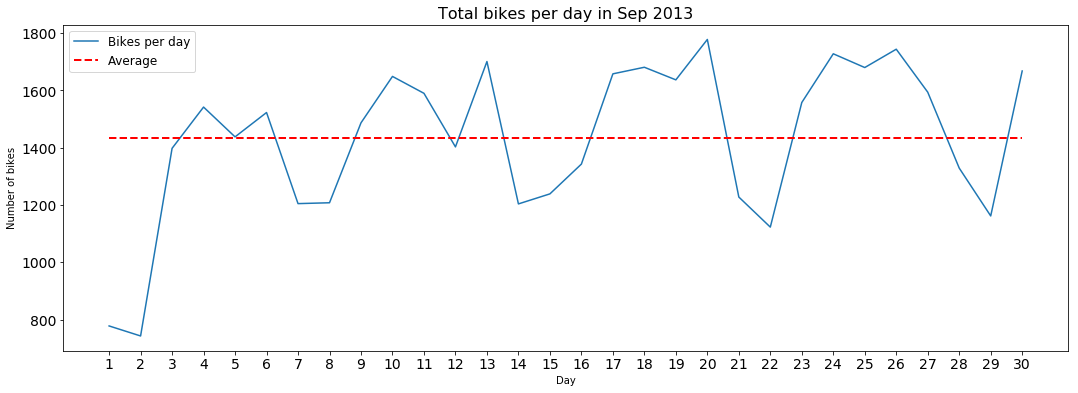

In [83]:
# Plotting Biker Stats for the entire september month - 2013
bike_daily = pd.DataFrame(data.groupby('start_day').size())
bike_daily['MEAN'] = data.groupby('start_day').size().mean()
bike_daily['STD'] = data.groupby('start_day').size().std()

# Plot total accidents per day, UCL, LCL and moving-average
plt.figure(figsize=(18,6))
data.groupby('start_day').size().plot(label='Bikes per day')
bike_daily['MEAN'].plot(color='red', linewidth=2, label='Average', ls='--')
plt.title('Total bikes per day in Sep 2013', fontsize=16)
plt.xlabel('Day')
plt.xticks(np.arange(1,31))
plt.ylabel('Number of bikes')
plt.tick_params(labelsize=14)
plt.legend(prop={'size':12})


#Conclusion:

   # The 'number of bikes' rises sharply in first 5 days of the month
   # The 'number of bikes' after 5th Sep is consistenly rise above & fall below average
   # There is a sharp drop in the 'number of bikes' between 20-22 Sep
   #The consistent drop in 'number of bikes' around certain dates suggests that these dates are weekends



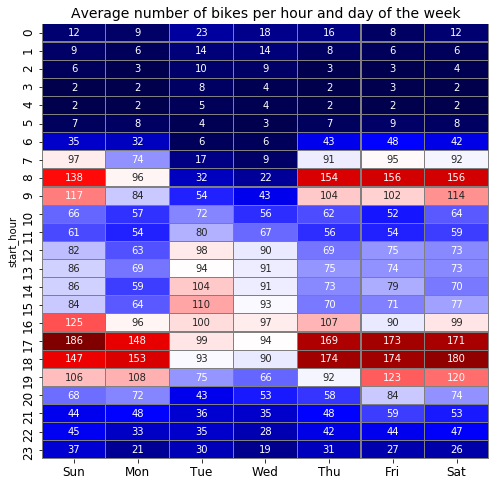

In [84]:
#Number of Bikes' Weekly Stats - Heatmap
# Create a pivot table by crossing the hour by the day of the week and calculate the average number of bikes for each crossing
bikes_pivot_table = data.pivot_table(values='start_day', index='start_hour', columns='weekday', aggfunc=len)
bikes_pivot_table_date_count = data.pivot_table(values='start_day', index='start_hour', columns='weekday', aggfunc=lambda x: len(x.unique()))
bikes_average = bikes_pivot_table/bikes_pivot_table_date_count
bikes_average.columns = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']

# Using seaborn heatmap
plt.figure(figsize=(8,8))
plt.title('Average number of bikes per hour and day of the week', fontsize=14)
plt.tick_params(labelsize=12)
sns.heatmap(bikes_average.round(), cmap='seismic', linecolor='grey',linewidths=0.1, cbar=False, annot=True, fmt=".0f")

In [ ]:
#
#Conclusion:

  #  Sunday, Thursday, Friday & Saturday has the highest 'number of bikes' for 8 AM time slot
   # Sunday, Thursday, Friday & Saturday has the highest 'number of bikes' for 5-7 PM time slot
    #The 10 AM - 3 PM time slot has moderate 'number of bikes'
    #Tuesdays & Wednesdays has low to moderate 'number of bikes' for any given time slot



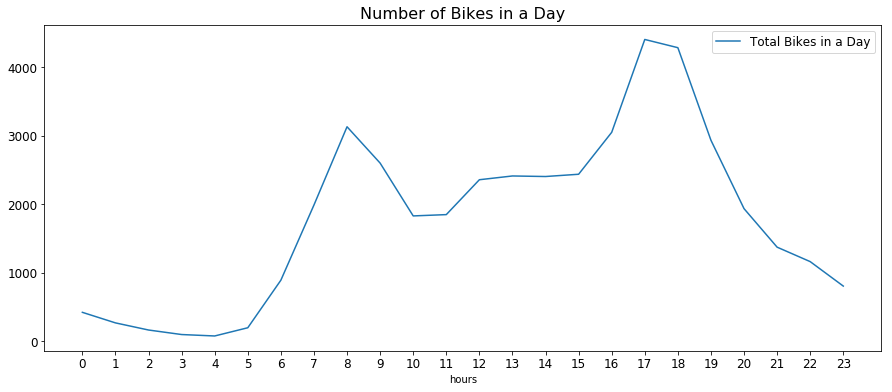

In [43]:

# Plotting - Bikes per Day
plt.figure(figsize=(15,6))

data.groupby('start_hour').size().plot(label = 'Total Bikes in a Day')
plt.title('Number of Bikes in a Day', fontsize=16)
plt.xlabel('hours')
plt.xticks(np.arange(0,24))
plt.legend(prop={'size':12})
plt.tick_params(labelsize=12)

In [ ]:

#Conclusion:

 #   The 'number of bikes' on the road is highest at 8 AM & between 5 - 6 PM
  #  The 'number of bikes' on the road is at its lowest around 3 -4 AM



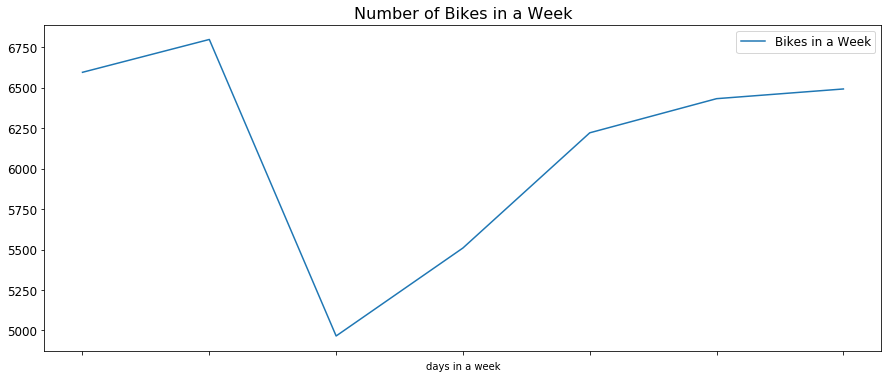

In [44]:

#'Number of Bikes' in a Week - Plot
# Number of Bikes in a week - plot
plt.figure(figsize=(15,6))

data.groupby('weekday').size().plot(label = 'Bikes in a Week')
plt.title('Number of Bikes in a Week', fontsize=16)
plt.xlabel('days in a week')
plt.legend(prop={'size':12})
plt.tick_params(labelsize=12)

In [ ]:

#Conclusion:

 #   The 'number of bikes' is low on Saturday
  #  The 'number of bikes' is higest on Monday



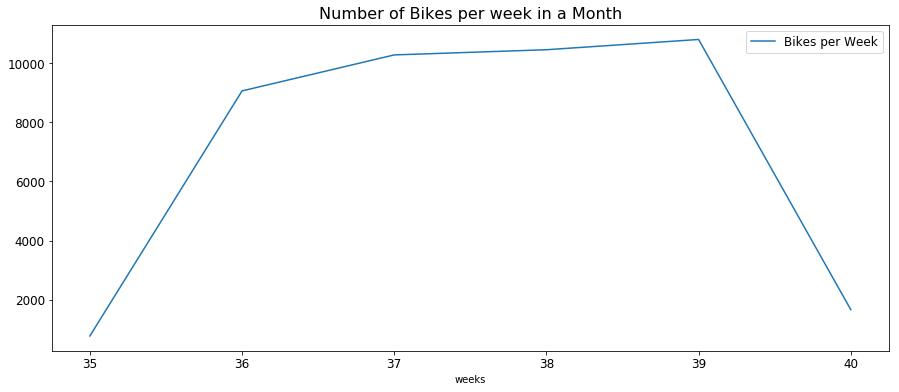

In [45]:
#Number of Bikes' per week in a month


# Plotting - Bikes in a Month
plt.figure(figsize=(15,6))

data.groupby('start_week').size().plot(label = 'Bikes per Week')
plt.title('Number of Bikes per week in a Month', fontsize=16)
plt.xlabel('weeks')
plt.legend(prop={'size':12})
plt.tick_params(labelsize=12)

In [46]:
#Conclusion:

   # The 'number of bikes' is low on Saturday
    #The 'number of bikes' is higest on Monday



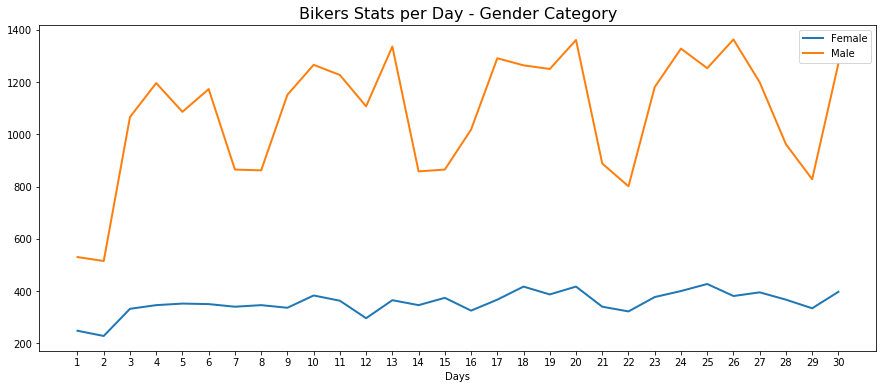

In [47]:
# Gender - Analysis & Visualisation

# Bikers Stats - Gender Category
bikes_stat_gender = data.pivot_table(values='gender', index='start_day', columns='Gender_Cat', aggfunc=len).plot(figsize=(15,6), linewidth=2)
plt.title('Bikers Stats per Day - Gender Category', fontsize=16)
plt.xlabel('Days')
plt.xticks(np.arange(1,31))
plt.legend(prop={'size':10})
plt.tick_params(labelsize=10)

In [ ]:
#Conclusion:
#    There fewer Female bikers than Male bikers
 #   Number of Female bikers are consistent in the month, however, Number of Male bikers has no consistency



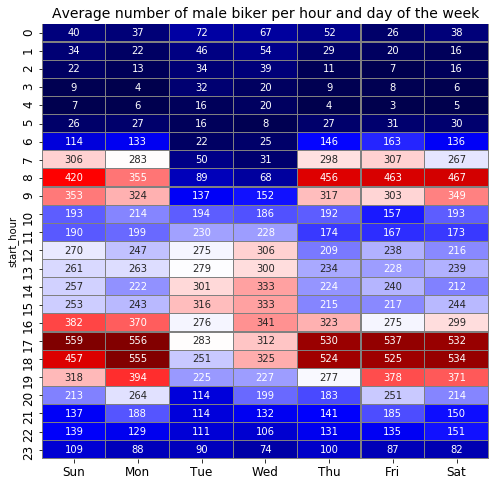

In [48]:
#Male Bikers Stats - Heatmap
# Male Bikers Heat Map
male_biker_df = data[data['gender'] == 1]##### by changing 1 to 2 we will female anaylsis
male_biker_pivot_table = male_biker_df.pivot_table(values='gender', index='start_hour', columns='weekday', aggfunc=len)
male_biker_pivot_table_date_count = male_biker_df.pivot_table(values='gender', index='start_hour', columns='weekday', aggfunc=lambda x: len(x.unique()))
male_biker_avg = male_biker_pivot_table/male_biker_pivot_table_date_count
male_biker_avg.columns = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']

# Using seaborn heatmap
plt.figure(figsize=(8,8))
plt.title('Average number of male biker per hour and day of the week', fontsize=14)
plt.tick_params(labelsize=12)
sns.heatmap(male_biker_avg.round(), cmap='seismic', linecolor='grey',linewidths=0.1, cbar=False, annot=True, fmt=".0f")


In [ ]:

#Conclusion:

 #   Number of Male bikers are high during 8 - 9 AM & 4 - 7 PM time slot on Sunday, Monday, Thursday, Friday & Saturday
  #  Number of Male bikers is moderate betwen 10 AM - 3 PM timeslot on any day
   # Tuesday & Wednesday have low to moderate number of Male Bikers
    #Male bikers are comfortable riding after hours i.e. during 8 - 11 PM timeslot



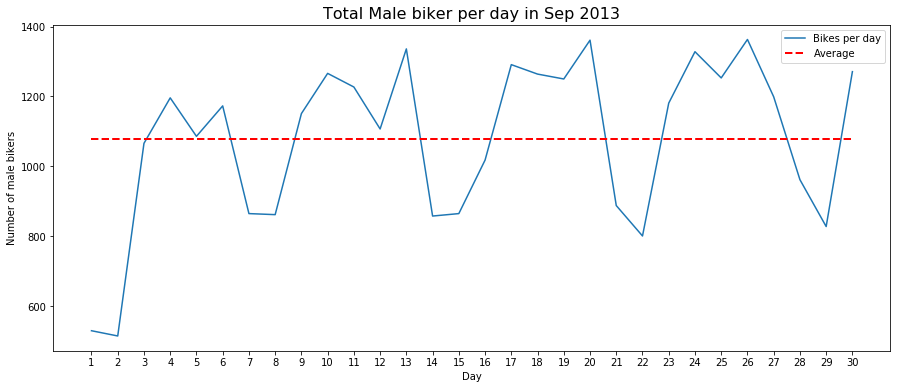

In [49]:
#Male Bikers in Month of September 2013
#  Male Bikers in month of september 2013
male_biker_daily = pd.DataFrame(male_biker_df.groupby('start_day').size())
male_biker_daily['MEAN'] = male_biker_df.groupby('start_day').size().mean()
male_biker_daily['STD'] = male_biker_df.groupby('start_day').size().std()

plt.figure(figsize=(15,6))
male_biker_df.groupby('start_day').size().plot(label='Bikes per day')
male_biker_daily['MEAN'].plot(color='red', linewidth=2, label='Average', ls='--')
plt.title('Total Male biker per day in Sep 2013', fontsize=16)
plt.xlabel('Day')
plt.ylabel('Number of male bikers')
plt.tick_params(labelsize=10)
plt.xticks(np.arange(1,31))
plt.legend(prop={'size':10})

In [ ]:

#Conclusion:

 #   Number of Male Bikers is at its lowest on 2 Sep 2013
  #  Number of Male Bikers are at its highest on 13, 20 & 26th Sep 2013
  #  Number of Male Bikers is above average during 3-6 , 9-13, 17-20 & 23-27 Sep 2013



In [50]:
# Number of Male Bikers in Day

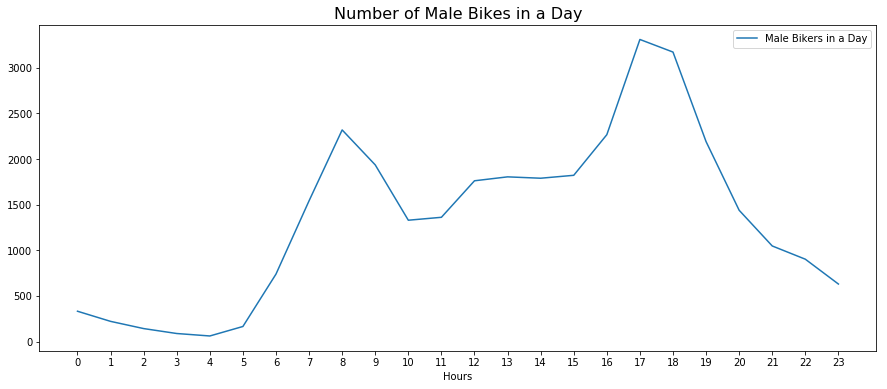

In [52]:
# Plotting - Male Biker in a Day
plt.figure(figsize=(15,6))

male_biker_df.groupby('start_hour').size().plot(label = 'Male Bikers in a Day')
plt.title('Number of Male Bikes in a Day', fontsize=16)
plt.xlabel('Hours')
plt.xticks(np.arange(0,24))
plt.legend(prop={'size':10})
plt.tick_params(labelsize=10)

In [ ]:
#Conclusion:

 #   Number of Male Bikers are low during early hours i.e. 4 - 5 AM
 #   Number of Male Bikers are high during 8 AM & 5 - 6 PM timeslot
  #   Number of Male Bikers sharply increase between 5 - 8 AM timeslot
   #   There are moderate number of Male Bikers on road after 8 PM



In [ ]:
#  Male Bikers Trip Duration - Plot


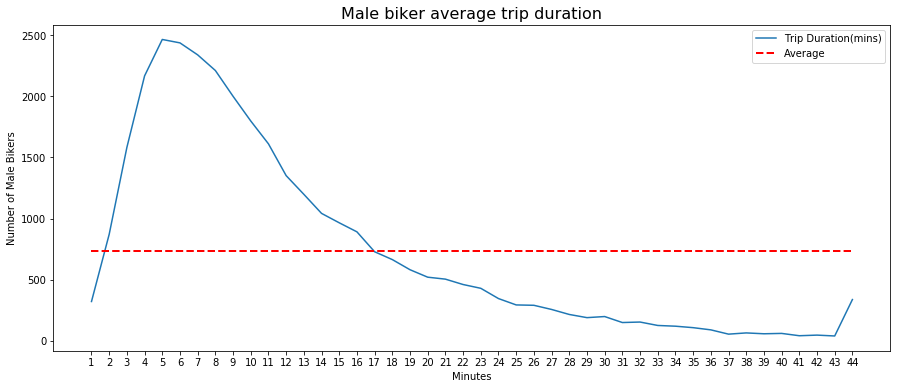

In [55]:
#male Bikers Trip Duration - Plot

# Male Bikers Average Trip Duration
male_biker_daily_trip = pd.DataFrame(male_biker_df.groupby('trip_duration_min').size())
male_biker_daily_trip['MEAN'] = male_biker_df.groupby('trip_duration_min').size().mean()
male_biker_daily_trip['STD'] = male_biker_df.groupby('trip_duration_min').size().std()

# Plot total accidents per day, UCL, LCL and moving-average
plt.figure(figsize=(15,6))
male_biker_df.groupby('trip_duration_min').size().plot(label='Trip Duration(mins)')
male_biker_daily_trip['MEAN'].plot(color='red', linewidth=2, label='Average', ls='--')
plt.title('Male biker average trip duration', fontsize=16)
plt.xlabel('Minutes')
plt.xticks(np.arange(1,45))
plt.ylabel('Number of Male Bikers')
plt.tick_params(labelsize=10)
plt.legend(prop={'size':10})





In [ ]:
#Conclusion:
#   A large number of Male Biker's average trip duration is between 5 - 8 minutes
 #   A very few Male Biker's average trip duration is between 40 - 43 minutes



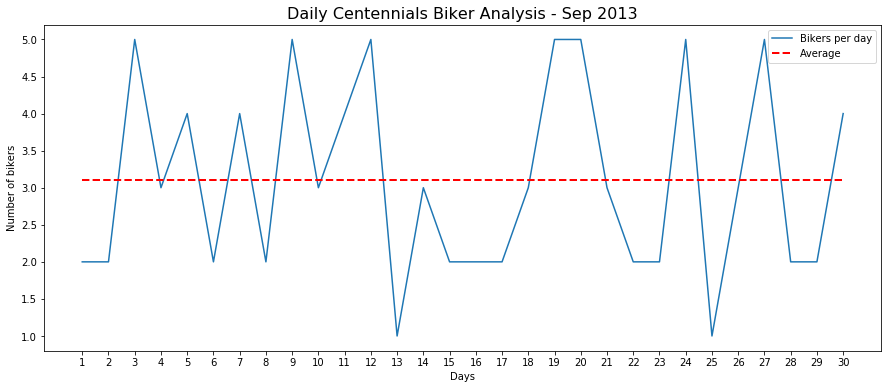

In [87]:
# Centennials Bikers Analysis - Month
CentennialBikers_df = data[data['birth_year'] >= 1996]

CentennialBikers_daily = pd.DataFrame(CentennialBikers_df.groupby('start_day').size())
CentennialBikers_daily['MEAN'] = CentennialBikers_df.groupby('start_day').size().mean()

plt.figure(figsize=(15,6))

CentennialBikers_df.groupby('start_day').size().plot(label='Bikers per day')
CentennialBikers_daily['MEAN'].plot(color='red', linewidth=2, label='Average',ls='--')
plt.title('Daily Centennials Biker Analysis - Sep 2013', fontsize=16)
plt.xlabel('Days')
plt.ylabel('Number of bikers')
plt.xticks(np.arange(1,31))
plt.tick_params(labelsize=10)
plt.legend(prop={'size':10})


#concllusion

   # Number of Centennial bikers are high on 3, 9, 19, 20, 24, 27 Sep 2013
  #  Number of Centennial bikers are very low on 13, 25 Sep 2013


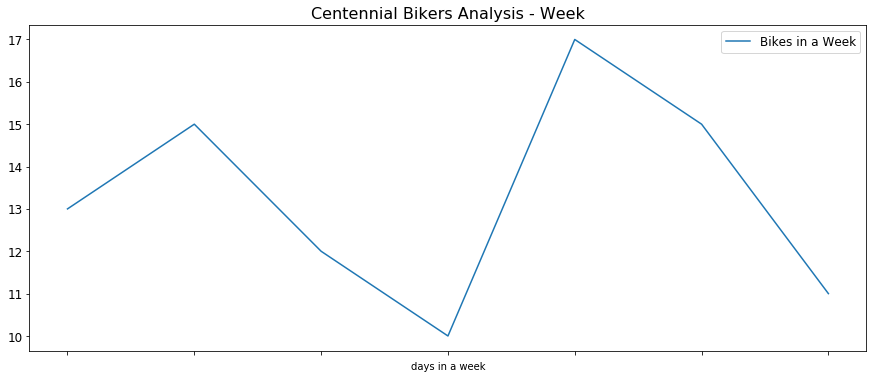

In [89]:

## Centennials Bikers Analysis - Week

# Centennial Bikers Analysis - Week
plt.figure(figsize=(15,6))

CentennialBikers_df.groupby('weekday').size().plot(label = 'Bikes in a Week')
plt.title('Centennial Bikers Analysis - Week', fontsize=16)
plt.xlabel('days in a week')
plt.legend(prop={'size':12})
plt.tick_params(labelsize=12)


# conclusion  
# Number of Centennial bikers is low on Sunday & high on Thursday

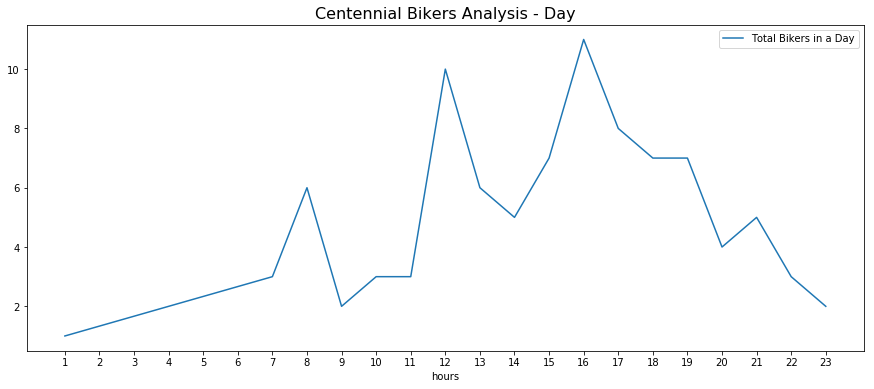

In [90]:
# Centennials Bikers Analysis - Day



# Centennial Bikers Analysis - Day
plt.figure(figsize=(15,6))

CentennialBikers_df.groupby('start_hour').size().plot(label = 'Total Bikers in a Day')
plt.title('Centennial Bikers Analysis - Day', fontsize=16)
plt.xlabel('hours')
plt.xticks(np.arange(1,24))
plt.legend(prop={'size':10})
plt.tick_params(labelsize=10)


# conclusion
#    Number of Centennial bikers is highat 12 PM & 4 PM
#    Number of Centennial bikers sharply increase between 7 - 8 AM, 11 AM - 12 PM. And drops sharply between 8 - 9 AM & 12 - 1 PM.


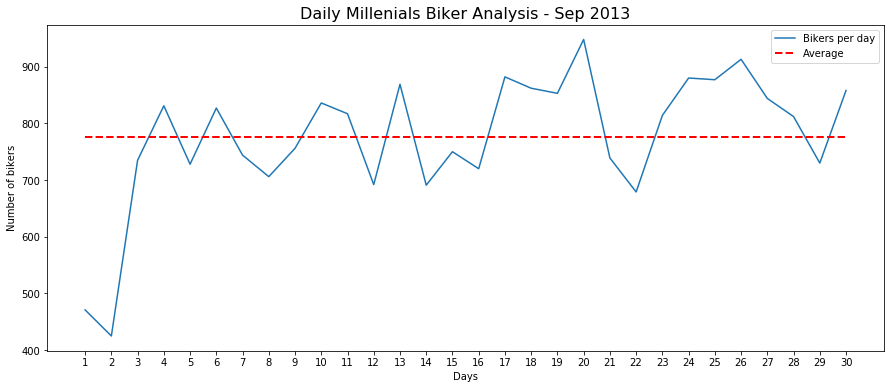

In [92]:
#millenials Bikers Analysis

# Millenials Bikers Analysis - Month
MillenialBikers_df = data[(data['birth_year'] >= 1977) & (data['birth_year'] <= 1995)]

MillenialBikers_daily = pd.DataFrame(MillenialBikers_df.groupby('start_day').size())
MillenialBikers_daily['MEAN'] = MillenialBikers_df.groupby('start_day').size().mean()

plt.figure(figsize=(15,6))

MillenialBikers_df.groupby('start_day').size().plot(label='Bikers per day')
MillenialBikers_daily['MEAN'].plot(color='red', linewidth=2, label='Average',ls='--')
plt.title('Daily Millenials Biker Analysis - Sep 2013', fontsize=16)
plt.xlabel('Days')
plt.ylabel('Number of bikers')
plt.xticks(np.arange(1,31))
plt.tick_params(labelsize=10)
plt.legend(prop={'size':10})


#
#Conclusion:¶

#    Lowest on 02 Sep 2013
#    Highest on 20 Sep 2013



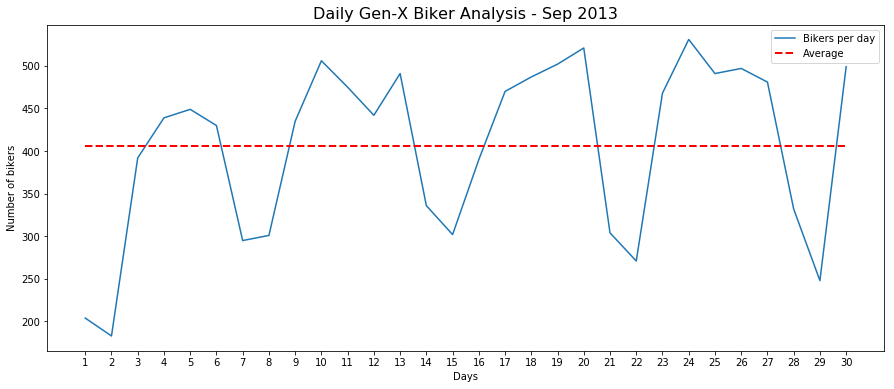

In [93]:
# Gen X Bikers Analysis - Month
GenX_df = data[(data['birth_year'] >= 1965) & (data['birth_year'] <= 1976)]

GenX_daily = pd.DataFrame(GenX_df.groupby('start_day').size())
GenX_daily['MEAN'] = GenX_df.groupby('start_day').size().mean()

plt.figure(figsize=(15,6))

GenX_df.groupby('start_day').size().plot(label='Bikers per day')
GenX_daily['MEAN'].plot(color='red', linewidth=2, label='Average',ls='--')
plt.title('Daily Gen-X Biker Analysis - Sep 2013', fontsize=16)
plt.xlabel('Days')
plt.ylabel('Number of bikers')
plt.xticks(np.arange(1,31))
plt.tick_params(labelsize=10)
plt.legend(prop={'size':10})

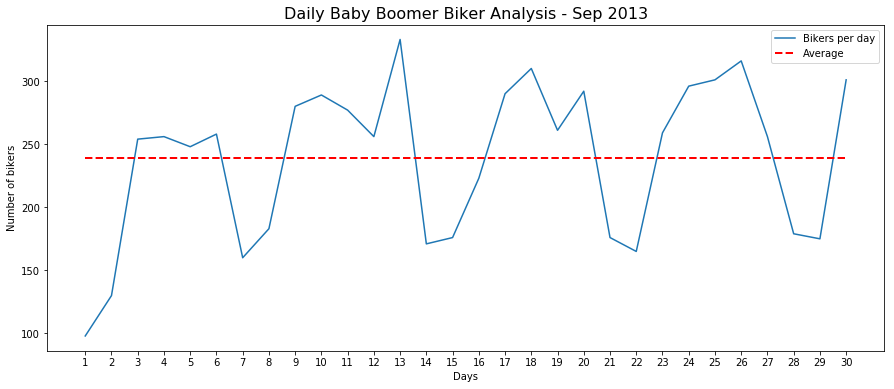

In [94]:

##Baby Boomers Bikers Analysis

# Baby Boomers Bikers Analysis - Month
BabyB_df = data[(data['birth_year'] >= 1946) & (data['birth_year'] <= 1964)]

BabyB_daily = pd.DataFrame(BabyB_df.groupby('start_day').size())
BabyB_daily['MEAN'] = BabyB_df.groupby('start_day').size().mean()

plt.figure(figsize=(15,6))

BabyB_df.groupby('start_day').size().plot(label='Bikers per day')
BabyB_daily['MEAN'].plot(color='red', linewidth=2, label='Average',ls='--')
plt.title('Daily Baby Boomer Biker Analysis - Sep 2013', fontsize=16)
plt.xlabel('Days')
plt.ylabel('Number of bikers')
plt.xticks(np.arange(1,31))
plt.tick_params(labelsize=10)
plt.legend(prop={'size':10})



In [56]:
###  Spatial Visualisation

data.head()

,bike_id,weekday,start_hour,start_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_time,end_station_id,...,start_month,start_week,start_day,end_year,end_month,end_week,end_day,end_hour,Gender_Cat,trip_duration_min
0,16013,Mon,18,2013-09-09 18:18:55,523,W 38 St & 8 Ave,40.754666,-73.991382,2013-09-09 18:35:28,334,...,9,37,9,2013,9,37,9,18,Female,16
1,15230,Thu,18,2013-09-12 18:38:53,257,Lispenard St & Broadway,40.719392,-74.002472,2013-09-12 18:48:34,236,...,9,37,12,2013,9,37,12,18,Male,9
2,17942,Wed,19,2013-09-18 19:44:04,479,9 Ave & W 45 St,40.760193,-73.991255,2013-09-18 19:50:05,513,...,9,38,18,2013,9,38,18,19,Male,6
3,19683,Sat,11,2013-09-28 11:54:37,527,E 33 St & 1 Ave,40.743156,-73.974347,2013-09-28 12:03:58,441,...,9,39,28,2013,9,39,28,12,Female,9
5,14581,Fri,22,2013-09-27 22:01:01,293,Lafayette St & E 8 St,40.730287,-73.990765,2013-09-27 22:08:08,432,...,9,39,27,2013,9,39,27,22,Female,7


In [67]:
# Function to create a base map of NY

def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start,width='50%', height='50%')
    return base_map

In [68]:
#Calling the base map function
base_map = generateBaseMap()
base_map

In [85]:
# Centennial Bikers - Heatmap

CentennialBikers_df_copy = CentennialBikers_df.copy()
CentennialBikers_df_copy['count'] = 1
base_map = generateBaseMap()
HeatMap(data=CentennialBikers_df_copy[['start_station_latitude', 'start_station_longitude', 'count']].groupby(['start_station_latitude', 'start_station_longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

#calling the function
base_map

In [95]:
# Millenial Bikers - Heatmap

MillenialBikers_df_copy = MillenialBikers_df.copy()
MillenialBikers_df_copy['count'] = 1
base_map = generateBaseMap()
HeatMap(data=MillenialBikers_df_copy[['start_station_latitude', 'start_station_longitude', 'count']].groupby(['start_station_latitude', 'start_station_longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

#calling the function
base_map

In [96]:
# Gen-X Bikers - Heatmap

GenX_df_copy = GenX_df.copy()
GenX_df_copy['count'] = 1
base_map = generateBaseMap()
HeatMap(data=GenX_df_copy[['start_station_latitude', 'start_station_longitude', 'count']].groupby(['start_station_latitude', 'start_station_longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

#calling the function
base_map

In [97]:
# Baby Boomer Bikers - Heatmap

BabyB_df_copy = BabyB_df.copy()
BabyB_df_copy['count'] = 1
base_map = generateBaseMap()
HeatMap(data=BabyB_df_copy[['start_station_latitude', 'start_station_longitude', 'count']].groupby(['start_station_latitude', 'start_station_longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

#calling the function
base_map

In [98]:
# Overall Male Biker - Heatmap

male_biker_df_copy = male_biker_df.copy()
male_biker_df_copy['count'] = 1
base_map = generateBaseMap()
HeatMap(data=male_biker_df_copy[['start_station_latitude', 'start_station_longitude', 'count']].groupby(['start_station_latitude', 'start_station_longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

#calling the function
base_map

In [ ]:
t